# ep9 trading with moving average

In this episode, we explore moving average-based trading strategy.  We first plot the price evolution of `SPY` on the same chart with the evolution of the 5-day and the 20-day moving average prices.

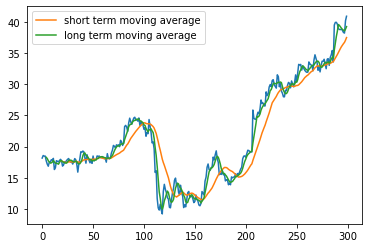

In [4]:
from my_stock import read_stock
df = read_stock('LB')
df_org = df.copy()
win_l = 20
win_s = 5
df['MAL'] = df['Close'].rolling(win_l).mean()
df['MAS'] = df['Close'].rolling(win_s).mean()
df = df.drop(['Open','High','Low','Adj Close','Volume'],axis=1)

import matplotlib.pyplot as plt
plt.plot(df['Close'])
plt.plot(df['MAL'],label='short term moving average')
plt.plot(df['MAS'],label='long term moving average')
plt.legend()
plt.show()

In the code block below, we will mark buy and sell signals based on the long- and short-term moving averages.  A short-term moving average higher than the long-term moving average suggests an developing upward trend and generates a buy signal.  On the other hand, a short-term moving average lower than the long-term moving average suggests a sell signal.

In [5]:
import pandas as pd
df['MAS gt. MAL']=df['MAS'] >= df['MAL']
pd.set_option('display.max_row',600)
df.head(10)

,Date,Close,MAL,MAS,MAS gt. MAL
0,2019-10-02,18.150000,NaN,NaN,False
1,2019-10-03,18.559999,NaN,NaN,False
2,2019-10-04,18.459999,NaN,NaN,False
3,2019-10-07,18.469999,NaN,NaN,False
4,2019-10-08,17.700001,NaN,18.268,False
5,2019-10-09,17.180000,NaN,18.074,False
6,2019-10-10,16.840000,NaN,17.730,False
7,2019-10-11,17.500000,NaN,17.538,False
8,2019-10-14,17.480000,NaN,17.340,False
9,2019-10-15,17.889999,NaN,17.378,False


In [6]:
def mark_sig(row,df):
    i = row.name
    if i == 0:
        return 'none'
    else:
        if (row['MAS gt. MAL'] == True) and (df.iloc[i-1]['MAS gt. MAL'] == False):
            return 'buy'
        if (row['MAS gt. MAL'] == False) and (df.iloc[i-1]['MAS gt. MAL'] == True):
            return 'sell'
        return 'none'
    
df['signal']=df.apply(mark_sig,args=(df,),axis=1)
df = df[df['signal']!='none']
df = df.drop(['MAS gt. MAL'],axis=1)

In [7]:
if df.iloc[-1]['signal']=='buy':
    df = df.drop([df.iloc[-1].name])
df_agg = df[['Close','signal']].groupby(by=['signal']).agg('prod')
strategy_gain = df_agg.loc['sell']['Close']/df_agg.loc['buy']['Close']-1
benchmark_gain = df_org.iloc[-1]['Close']/df_org.iloc[0]['Close']-1
print('strategy gain (%): {:.2f}, benchmark gain (%): {:.2f}'.format(strategy_gain*100,benchmark_gain*100))

strategy gain (%): 100.14, benchmark gain (%): 125.67


We will now package the routines developed above into one function, which will be repeated applied to all SP500 stocks.

In [9]:
from my_stock import read_stock

def mark_sig(row,df):
    i = row.name
    if i == 0:
        return 'none'
    else:
        if (row['MAS gt. MAL'] == True) and (df.iloc[i-1]['MAS gt. MAL'] == False):
            return 'buy'
        if (row['MAS gt. MAL'] == False) and (df.iloc[i-1]['MAS gt. MAL'] == True):
            return 'sell'
        return 'none'
    
def proc_stock(df,win_l,win_s):    
    df['MAL'] = df['Close'].rolling(win_l).mean()
    df['MAS'] = df['Close'].rolling(win_s).mean()    
    df['MAS gt. MAL']=df['MAS'] >= df['MAL']
    df['signal']=df.apply(mark_sig,args=(df,),axis=1)
    df_sig = df[df['signal']!='none']    
    if df_sig.iloc[-1]['signal']=='buy':
        df_sig = df_sig.drop([df_sig.iloc[-1].name])
    return df_sig    

def paper_trade(df_sig,df):
    try:
        df_agg = df_sig[['Close','signal']].groupby(by=['signal']).agg('prod')
        strategy_gain = df_agg.loc['sell']['Close']/df_agg.loc['buy']['Close']-1
        benchmark_gain = df.iloc[-1]['Close']/df.iloc[0]['Close']-1
        return [strategy_gain,benchmark_gain]
    except:
        return [np.nan,np.nan]
    
def analyze_stock(df,win_l,win_s):        
    df_sig = proc_stock(df,win_l,win_s)
    return paper_trade(df_sig,df)

df = read_stock('LB')
print(analyze_stock(df,win_l,win_s))

[1.0014177907385933, 1.256749256198347]


In [10]:
import pandas as pd
df_SP500 = pd.read_csv('SP500 list.csv')
ls_res = list(df_SP500['Symbol'].apply(read_stock).apply(analyze_stock,args=(20,5)))

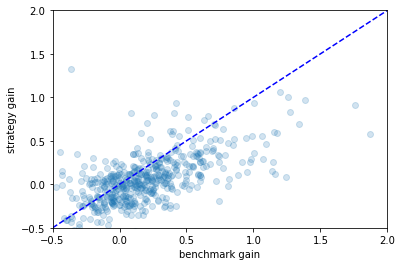

In [13]:
df_res = pd.DataFrame(ls_res,columns=['strategy gain','benchmark gain'])
df_res.head(10)
plt.scatter(df_res['benchmark gain'],df_res['strategy gain'],alpha=0.2)
plt.plot([-0.5,2],[-0.5,2],'b--')
plt.xlabel('benchmark gain')
plt.xlim((-0.5,2))
plt.ylim((-0.5,2))
plt.ylabel('strategy gain')
plt.show()

It appears that the strategy using 5- and 20- moving averages does not consistently produce higher gain for all stocks.  We will now explore the other window sizes to understand the effect of window size on the gain.  We will use `SPY` as the subject of this exploration.

In [14]:
def opti(symbol):
    win_l = range(15,26)
    win_s = range(3,8)
    ls_res = []
    df = read_stock(symbol)
    if len(df) == 0:
        pass
    else:
        for i in win_l:
            for j in win_s:
                strategy_gain,benchmark_gain = analyze_stock(df,i,j)
                ls_res.append([symbol,i,j,strategy_gain,benchmark_gain])    
        return sorted(ls_res,key=lambda x: x[3],reverse=True)[0]

opti('SPY')

['SPY', 18, 6, 0.40108554158912346, 0.2850448363885636]

As can be seen from the code block above, optimization on the window sizes provided a boost in the performance of the trading strategy.  We will now perform this optimization for each and every one of the SP500 stocks.

When this program was used to optimize the trading strategy parameters of all SP500 stocks, the runtime is extremely long.  When no response can be observed after waiting for a long time, one wonders whether the program has stopped responding or the calculation is still in progress.  In order to prevent such confusion, the program was executed in a console terminal.  The resulting parameter table is saved in `opti_ma.csv`.

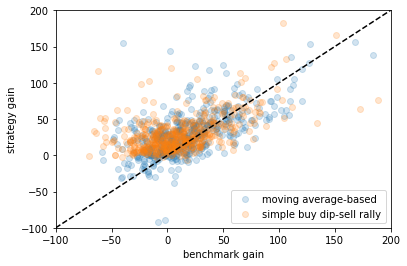

In [3]:
import pandas as pd
df_ma_opti = pd.read_csv('opti_ma.csv')
df_bdsr_opti = pd.read_csv('opti.csv')
df_ma_opti.head(10)
df_bdsr_opti.head(10)

import matplotlib.pyplot as plt
plt.scatter(df_ma_opti['benchmark gain']*100,df_ma_opti['strategy gain']*100,alpha=0.2,label='moving average-based')
plt.scatter(df_bdsr_opti['Benchmark Gain %'],df_bdsr_opti['Max. Strategy Gain %'],alpha=0.2,label='simple buy dip-sell rally')
plt.plot([-100,200],[-100,200],'k--')
plt.xlim([-100,200])
plt.ylim([-100,200])
plt.xlabel('benchmark gain')
plt.ylabel('strategy gain')
plt.legend()
plt.show()

Comparing this figure with the figure above, one notices that optimization leads increased gain by the trading strategy.  In addition, it appears that the optimized gain produced by the moving average-based trading algorithm produces similar performance as the simple buy dip-sell rally algorithm.